<a href="https://colab.research.google.com/github/BuilderHut/Sioc_Lab/blob/main/spr3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-5-fed9cda28beb>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wynik[wiersz, kolumna] = jadro(np.array([x]), x_podloga, 1, tryb) * jadro(np.array([y]), y_podloga, 1, tryb)


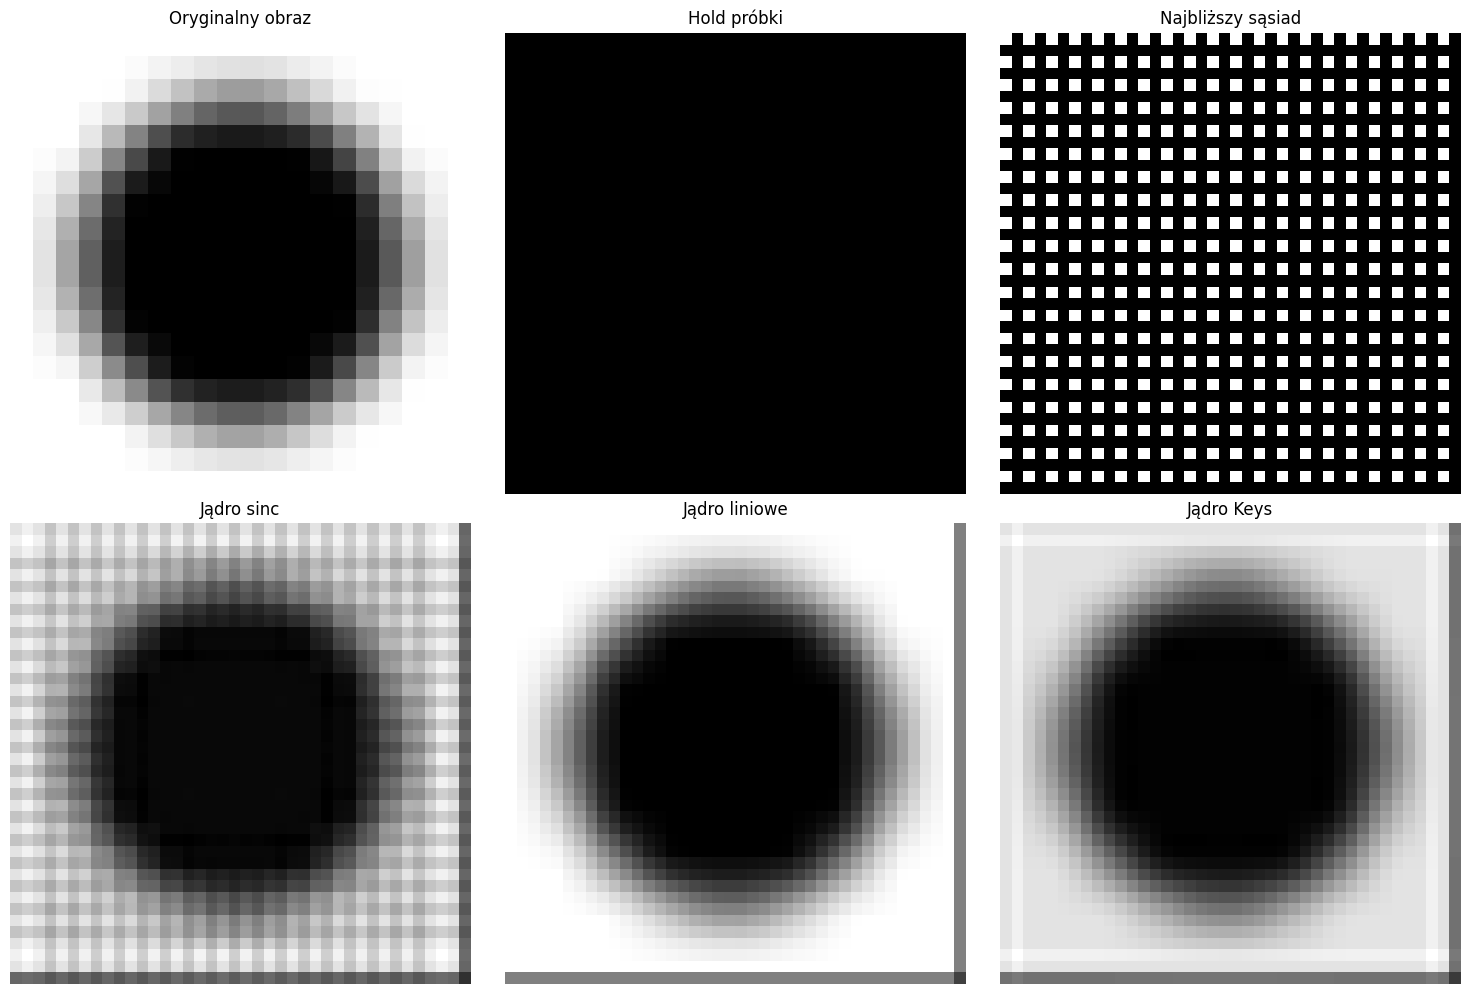

In [5]:
import numpy as np
from numpy.typing import NDArray
from PIL import Image
import matplotlib.pyplot as plt

def jadro(punkty: NDArray, przesuniecie: float | NDArray, szerokosc: float, tryb: str = "Hs") -> NDArray:

    if tryb == "Hs":
        wynik = np.logical_and(0 <= (punkty - przesuniecie), (punkty - przesuniecie) < szerokosc).astype(float)
    elif tryb == "Hn":
        wynik = np.logical_and(-szerokosc / 2 <= (punkty - przesuniecie), (punkty - przesuniecie) < szerokosc / 2).astype(float)
    elif tryb == "sinc":
        wynik = np.sinc(punkty - przesuniecie) * (np.abs(punkty - przesuniecie) < szerokosc)
    elif tryb == "linear":
        wynik = np.maximum(0, 1 - np.abs(punkty - przesuniecie))
    elif tryb == "keys":
        a = -0.5
        abs_x = np.abs(punkty - przesuniecie)
        wynik = np.where(
            abs_x < 1,
            (a + 2) * abs_x**3 - (a + 3) * abs_x**2 + 1,
            np.where(abs_x < 2, a * abs_x**3 - 5 * a * abs_x**2 + 8 * a * abs_x - 4 * a, 0),
        )
    else:
        raise ValueError("Nieprawidłowy tryb jądra. Użyj 'Hs', 'Hn', 'sinc', 'linear' lub 'keys'.")
    return wynik

def interpoluj_obraz2d(obraz: NDArray, wspolczynnik: int, tryb: str = "Hs") -> NDArray:

    if obraz.ndim == 3:
        kanaly = [interpoluj_obraz2d(obraz[:, :, k], wspolczynnik, tryb) for k in range(obraz.shape[2])]
        return np.stack(kanaly, axis=2)

    wysokosc, szerokosc = obraz.shape
    nowa_wysokosc, nowa_szerokosc = wysokosc * wspolczynnik, szerokosc * wspolczynnik
    wynik = np.zeros((nowa_wysokosc, nowa_szerokosc), dtype=float)

    for wiersz in range(nowa_wysokosc):
        for kolumna in range(nowa_szerokosc):
            x = wiersz / wspolczynnik
            y = kolumna / wspolczynnik
            x_podloga, y_podloga = int(np.floor(x)), int(np.floor(y))
            x_podloga = min(x_podloga, wysokosc - 1)
            y_podloga = min(y_podloga, szerokosc - 1)

            if tryb in ["Hs", "Hn"]:
                wynik[wiersz, kolumna] = jadro(np.array([x]), x_podloga, 1, tryb) * jadro(np.array([y]), y_podloga, 1, tryb)
            else:
                jadro_x = jadro(np.arange(wysokosc), x, szerokosc=2, tryb=tryb)
                jadro_y = jadro(np.arange(szerokosc), y, szerokosc=2, tryb=tryb)
                wynik[wiersz, kolumna] = np.sum(jadro_x[:, None] * jadro_y[None, :] * obraz)

    return wynik


sciezka_obrazu = "imagee.png"
oryginalny_obraz = Image.open(sciezka_obrazu)
obraz_np = np.array(oryginalny_obraz)

wspolczynnik_powiekszenia = 2

obraz_Hs = interpoluj_obraz2d(obraz_np, wspolczynnik=wspolczynnik_powiekszenia, tryb="Hs")
obraz_Hn = interpoluj_obraz2d(obraz_np, wspolczynnik=wspolczynnik_powiekszenia, tryb="Hn")
obraz_sinc = interpoluj_obraz2d(obraz_np, wspolczynnik=wspolczynnik_powiekszenia, tryb="sinc")
obraz_liniowy = interpoluj_obraz2d(obraz_np, wspolczynnik=wspolczynnik_powiekszenia, tryb="linear")
obraz_keys = interpoluj_obraz2d(obraz_np, wspolczynnik=wspolczynnik_powiekszenia, tryb="keys")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.title("Oryginalny obraz")
plt.imshow(obraz_np if obraz_np.ndim == 3 else obraz_np, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Hold próbki")
plt.imshow(obraz_Hs if obraz_Hs.ndim == 3 else obraz_Hs, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Najbliższy sąsiad")
plt.imshow(obraz_Hn if obraz_Hn.ndim == 3 else obraz_Hn, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Jądro sinc")
plt.imshow(obraz_sinc if obraz_sinc.ndim == 3 else obraz_sinc, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Jądro liniowe")
plt.imshow(obraz_liniowy if obraz_liniowy.ndim == 3 else obraz_liniowy, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Jądro Keys")
plt.imshow(obraz_keys if obraz_keys.ndim == 3 else obraz_keys, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

